# A Text Mining Approach to Analyze The Cyber Security Related Articles

## PART-3: Text Mining

__Feature Engineering with NLP techniques__


__Importing of Required Libraries__

In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pickle
import re

import spacy
import en_core_web_sm
from spacy import displacy

import string
from num2words import num2words

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

__Loading Data__

As mentioned Part-2 that pandas parquet options doesn't support timedelta type. So we need to use __fastparquet__ option, to keep the timedelta type format.

In [2]:
df_sum=pd.read_parquet('df_sum_parquet.gzip',engine='fastparquet')
df_investigator_cyber=pd.read_parquet('df_investigator_cyber_parque.gzip',engine='fastparquet')
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


## A-) Clustering and Topic Modeling

In [3]:
#Create a new DataFrame
df_sum2=df_sum[['AwardID','AwardTitle','Abstract']]
df_sum2.head(2)

,AwardID,AwardTitle,Abstract
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a series of exp...
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...


__Replacing Of Contraction Words__

In [4]:
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":""}

df_sum2['Abstract'].replace(replacement_patterns, regex=True, inplace=True)
df_sum2.head(2)

,AwardID,AwardTitle,Abstract
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a series of exp...
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...


__Removing Unneccesery Words__

We use __NER__ (Named Entity Recognition) function of __spacy__ library to detect named entities (people, places, organizations, dates, times etc.) from the text. After analyzing this words, we understood that they are unnecessary for clustering.

An example of visualization of NER:

In [5]:
#define the nlp object
nlp = en_core_web_sm.load()

#example text
doc=nlp(str(df_sum2['Abstract'][1]))

#visualization
displacy.render(doc, style="ent",jupyter=True)

In [6]:
#create a list for NER
NER_list=[]

#Find
for n in range(df_sum2.shape[0]):
    doc=nlp(str(df_sum2['Abstract'][n]))

    for ent in doc.ents:
        NER_list.append(ent.text)

NER_list = [' {0} '.format(elem) for elem in NER_list] #Add space to begins and ends of all NERs to prevent the 
print('Total NER words: {}'.format(len(NER_list)))
NER_list=list(set(NER_list)) #for unique elements in list
print('Total unique NER words: {}'.format(len(NER_list)))

print('Total words before removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

for NER in NER_list:
    df_sum2['Abstract']=df_sum2['Abstract'].str.replace(NER,' ',regex=False) #regex=False>> because, some NERs have punctuation
print('Total words after removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

Total NER words: 64069
Total unique NER words: 18654
Total words before removing NER: 11239471
Total words after removing NER: 10507239


__Tokenization and LowerCase__

In [8]:
#word tokenization and lowercase
df_sum2['Abstract_Tokens'] = df_sum2['Abstract'].str.lower().apply(nltk.word_tokenize)
print('Total words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words: 1653058


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[the, investigators, will, conduct, a, of, exp..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Numbers__

In [9]:
#remove numbers
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words consist of only alphabets: 1428418


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[the, investigators, will, conduct, a, of, exp..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Written Form of Numbers__

In [10]:
#Create a list about numbers in written form for ignoring
num2words_list=[]

for n in range(100):
    num=num2words(n)
    num2words_list.append(num)
    num_ord=num2words(n, ordinal=True)
    num2words_list.append(num_ord)
num2words_list=[n.replace('-','') for n in num2words_list]#remove the "-" punctuation

for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if w not in num2words_list]
print('Total words after removing written form of numbers: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing written form of numbers: 1427881


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[the, investigators, will, conduct, a, of, exp..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Stopwords__

In [11]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via','able','could','able','whether',
                      'either','unfortunately'])

#extend the stopwords list with unneccessary words for this study
stopwords_list.extend(['abstract','program','pi'])


for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing stopwords: 843444


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigators, conduct, experiments, focus, c..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produces, cadre, computer, scientists, strong..."


__Lemmatization with POS Tag__

In [13]:
#define lemmatizer() object
lemmatizer = WordNetLemmatizer()

#lemmatize with POS Tag
def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in df_sum2['Abstract_Tokens'][n]]

print('Total words after lemmatization: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after lemmatization: 843444


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


__Remove 1-Length Words__

Punctuation
Punctuation are the unnecessary symbols that are in our corpus documents,

In [14]:
#remove 1-len words
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if len(w)>=2]
print('Total words after removing 1-len words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing 1-len words: 842590


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


__Remove Meaningless Words__

We can try to create a 'English Wordlist' from nltk with __nltk.corpus.words.words()__ method. But this wordlist has 236736 words. In this list some important words like 'internet', 'online', 'monitoring', 'firewall', 'crypto' etc.

In this study, we prefer to use a comprehensive wordlist from a [github account](https://github.com/dwyl/english-words) which has 370104 words. But still, we need to add some critical words to list like 'cyberinfrastructure','cybersecurity' etc. So we extended the our wordlist.

In [15]:
#Scrape a wordlist
url='https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt'
data = pd.read_csv(url,  header=None)
wordlist=list(data[0].values)
wordlist.extend(['cyberinfrastructure','cybersecurity','ci']) #extend the list with critical terms

meaningless_list=[]
#Check the tokens from wordlist
for n in range(df_sum2.shape[0]):
    meaningless=[w for w in  df_sum2['Abstract_Tokens'][n] if w not in wordlist]
    meaningless_list.extend(meaningless)
    df_sum2['Abstract_Tokens'][n]=[w for w in  df_sum2['Abstract_Tokens'][n] if w in wordlist]
print('Total words after removing the meaningless words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing the meaningless words: 821247


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


In [16]:
print(set(meaningless_list))

{'delawaretitle', 'lamont', 'tobacsig', 'endogeneity', 'tek', 'rodrigo', 'carefullydeveloping', 'blwt', 'tocttou', 'sunyit', 'nanowaveguiding', 'governmentlaboraties', 'bctc', 'withouthaving', 'finholtinstitution', 'fidmt', 'veriand', 'paleogeoscience', 'itrustso', 'maravelias', 'onboarding', 'markerless', 'murugesu', 'methathesis', 'underwaterbecause', 'reu', 'biomineralization', 'ourstudy', 'plcs', 'hokiespeed', 'threedimensional', 'meritcyberinfrastructure', 'utep', 'navdat', 'multispectral', 'beckman', 'shellcodebeing', 'explicitlyprogramming', 'bsns', 'myglucohealth', 'improvedefficiencies', 'smes', 'rov', 'neuroprostheses', 'qudits', 'ggsfp', 'lifemapper', 'cofunding', 'cci', 'intiaitive', 'collaborationsand', 'smte', 'dsu', 'turbopumped', 'paleobiologists', 'foundationproposal', 'starburstt', 'fixturing', 'noveltechniques', 'countersintellectual', 'sens', 'socioecological', 'espar', 'lablets', 'energyproduction', 'entropic', 'microfluidics', 'nanobuilding', 'bentcore', 'umbc', '

Abstract2 uniqi!!!
#Recounting the Words Frequency
freq_dict=nltk.FreqDist(wrd_list_lemmas)

print('Total unique words after lemmatization: {}'.format(len(freq_dict)))


__Convert Tokens To String For Tf-idf Vectorize__

In [17]:
df_sum2['Tokens_String']=df_sum2['Abstract']
for n in range(df_sum2.shape[0]):
    df_sum2['Tokens_String'][n]=' '.join([str(item) for item in df_sum2['Abstract_Tokens'][n]])
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...


__TfidfVectorizer__

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X = v.fit_transform(df_sum2['Tokens_String'])
X.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
print('First 10 Feature Name:\n {}'.format(v.get_feature_names()[:10]))

First 10 Feature Name:
 ['aa', 'aaa', 'ab', 'abandonment', 'abdomen', 'aberrant', 'abet', 'abide', 'ability', 'abiotic']


In [27]:
print('Total Feature Number: {}'.format(len(v.vocabulary_)))

Total Feature Number: 13021


__Create New DataFrame For Clustering__

In [29]:
df_for_clustering = pd.DataFrame(data=X.toarray(), columns=v.get_feature_names())
df_for_clustering.head(2)

,aa,aaa,ab,abandonment,abdomen,aberrant,abet,abide,ability,abiotic,...,zip,zircon,zonal,zone,zoo,zoom,zoonotic,zooplankton,zurich,zwitterionic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__Add The 'Top Word' and 'Top Word Frequency' To Each Row__

In [31]:
df_sum2['Top_Word']=df.idxmax(axis=1)
df_sum2['Top_Word_Freq']=df.max(axis=1)
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String,Top_Word,Top_Word_Freq
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...,restorative,0.604803
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...,assurance,0.355636


__KMeans Clustering__

Modeling with k-means: 1 is finish...
Modeling with k-means: 2 is finish...
Modeling with k-means: 3 is finish...
Modeling with k-means: 4 is finish...
Modeling with k-means: 5 is finish...


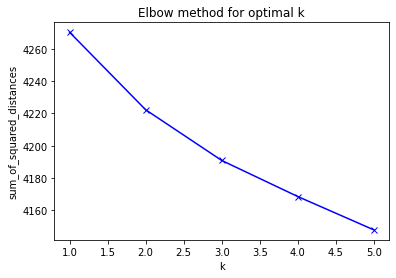

In [32]:

#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
sum_of_squared_distances = []

K_top=6 #
K = range(1,K_top)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(df_for_clustering)
    sum_of_squared_distances.append(k_means.inertia_)
    print('Modeling with k-means: {} is finish...'.format(k))
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.show()

In [33]:
n_clusters=3

In [34]:

k_means = KMeans(n_clusters=n_clusters)
#Run the clustering algorithm
model = k_means.fit(df_for_clustering)
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)
y_hat

array([0, 2, 2, ..., 0, 0, 0])

In [94]:
labels=list(y_hat)
df_sum2['Label']=labels
df_sum2.to_csv('df_sum_clustering.csv',sep=';')
for n in range(n_clusters):
    print('Topic {}: Total research paper is {}'.format(n, df_sum2[df_sum2['Label']==n].shape[0]))
df_sum2.head(2)

Topic 0: Total research paper is 2328
Topic 1: Total research paper is 1504
Topic 2: Total research paper is 721


,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String,Top_Word,Top_Word_Freq,Label
0,110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...,restorative,0.604803,0
1,112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...,assurance,0.355636,2


__Create New DataFrame with Topic Words__

In [36]:
df_cluster_words = pd.DataFrame(columns=['TopicWords','TopicWord','TopicTitle','TopicAbstract'], index=range(n_clusters))
for n in range(n_clusters):
    df_cluster_words.loc[n].TopicWords=list(df_sum2[df_sum2['Label']==n]['Top_Word'])
    df_cluster_words.loc[n].TopicWord=list(set(df_sum2[(df_sum2['Label']==n)&(df_sum2['Top_Word_Freq']>0.75)]['Top_Word'].values))
    df_cluster_words.loc[n].TopicTitle=df_sum2[df_sum2['Label']==n].sort_values(by='Top_Word_Freq',ascending=False)[:1]['AwardTitle'].values
    df_cluster_words.loc[n].TopicAbstract=df_sum2[df_sum2['Label']==n].sort_values(by='Top_Word_Freq',ascending=False)[:1]['Abstract'].values
df_cluster_words.to_csv('df_cluster_words.csv',sep=';')
df_cluster_words

,TopicWords,TopicWord,TopicTitle,TopicAbstract
0,"[restorative, packet, chaotic, algebra, sensor...","[transit, sketch, cpi, artist, emotion, compil...",[EXP: Attention-Aware Cyberlearning to Detect ...,[The ability to concentrate on tasks is critic...
1,"[arkansas, geoscience, geoscience, history, ab...","[gateway, permafrost, hydrologic, combustion, ...",[Collaborative Research: Development of Inform...,[0413182HellyThis proposal will advance integr...
2,"[assurance, assurance, externship, program, ex...","[forensics, creat]","[""Gamified"" Digital Forensics Course Modules f...",[Cybersecurity and forensics are critical area...


__Word Cloud__

Topic 0: Total research paper is 2328
Topic 1: Total research paper is 1504
Topic 2: Total research paper is 721


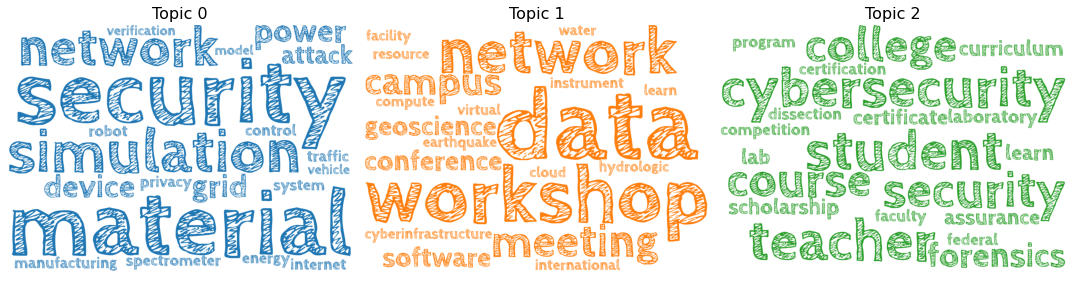

In [100]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(
                  background_color='white',
                  font_path='CabinSketch-Bold.ttf', #we copied spesific font to the folder
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = ', '.join(list(dict(nltk.FreqDist(df_cluster_words['TopicWords'][i]).most_common(20))))
    cloud.generate(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    print('Topic {}: Total research paper is {}'.format(i, df_sum2[df_sum2['Label']==i].shape[0]))

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### B-) Word Frequency

__Reload The Data__

In [101]:
df_sum2=pd.read_csv('df_sum_clustering.csv', sep=';').drop(['Unnamed: 0'],axis=1)
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String,Top_Word,Top_Word_Freq,Label
0,110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"['investigator', 'conduct', 'experiment', 'foc...",investigator conduct experiment focus crucial ...,restorative,0.604803,0
1,112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"['produce', 'cadre', 'computer', 'scientist', ...",produce cadre computer scientist strong specia...,assurance,0.355636,2


__Change the Tokens Type as 'list'__

In [102]:
df_sum2['Abstract_Tokens']=df_sum2['Abstract_Tokens'].str.replace("'","") #Remove the quotes
df_sum2['Abstract_Tokens'] = df_sum2['Abstract_Tokens'].apply(lambda x: x[1:-1].split(', ')) #Convert string to list
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String,Top_Word,Top_Word_Freq,Label
0,110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...,restorative,0.604803,0
1,112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...,assurance,0.355636,2


In [103]:
abstract_keyword_list=[]
for n in range(df_sum2.shape[0]):
    abstract_keyword_list.extend(df_sum2['Abstract_Tokens'][n])
print('Total words in abstract: {}'.format(len(abstract_keyword_list)))

Total words in abstract: 821247


__Counting The Words Frequency__

Pay attention!!! The total number of unique words in the abstract should be equal the 'tf-idf vectorize' columns number. Because both of them use the same counting method.

In [104]:
# Words Frequency
abstract_freq_dict=nltk.FreqDist(abstract_keyword_list)
print('Total unique words in abstract: {}'.format(len(abstract_freq_dict)))

Total unique words in abstract: 13021


In [105]:
#Frequencies of most common 50 words
print('First 50 frequency words:\n{}'.format(abstract_freq_dict.most_common(50)))

First 50 frequency words:
[('project', 12592), ('research', 11833), ('data', 8986), ('system', 8756), ('student', 7767), ('use', 7377), ('new', 5431), ('support', 5141), ('science', 5082), ('provide', 4938), ('model', 4698), ('include', 4467), ('community', 4236), ('design', 4194), ('develop', 4193), ('network', 4179), ('learn', 3728), ('impact', 3697), ('development', 3544), ('technology', 3425), ('security', 3378), ('tool', 3316), ('engineering', 2931), ('software', 2916), ('education', 2831), ('information', 2795), ('application', 2700), ('work', 2622), ('researcher', 2563), ('infrastructure', 2532), ('compute', 2472), ('resource', 2470), ('need', 2466), ('material', 2459), ('cybersecurity', 2442), ('cyberinfrastructure', 2420), ('study', 2353), ('scientific', 2349), ('activity', 2333), ('enable', 2326), ('understand', 2319), ('result', 2294), ('award', 2249), ('computational', 2225), ('workshop', 2219), ('control', 2180), ('make', 2173), ('analysis', 2165), ('address', 2141), ('hig

In [106]:
#Frequency of a specific word
print("The frequency of word 'internet': {}".format(abstract_freq_dict['internet']))

The frequency of word 'internet': 724


__Save The Result__

In [107]:
df_FreqDist=pd.DataFrame({'Words':list(abstract_freq_dict.keys()),'Count':list(abstract_freq_dict.values())})
df_FreqDist.sort_values(by=['Count'],ascending=False,inplace=True)
df_FreqDist=df_FreqDist.reset_index(drop=True)
df_FreqDist.to_csv('FreqDist.csv', sep=';')
df_FreqDist.head(2)

,Words,Count
0,project,12592
1,research,11833


### C-) Terms Analyse

__Load The Data__

In [111]:
df_term=pd.read_csv('IT_cyber_term.csv', sep=';')
df_term.head(2)

,Words,IT,Cyber,Cyber_Specific
0,agent,1,NaN,NaN
1,algorithm,1,NaN,NaN


In [114]:
most_common_list=list(dict(abstract_freq_dict.most_common(50)))
most_common_list[:5]

['project', 'research', 'data', 'system', 'student']

In [116]:
nltk.pos_tag(most_common_list)

[('project', 'NN'),
 ('research', 'NN'),
 ('data', 'NNS'),
 ('system', 'NN'),
 ('student', 'NN'),
 ('use', 'VBP'),
 ('new', 'JJ'),
 ('support', 'NN'),
 ('science', 'NN'),
 ('provide', 'VBP'),
 ('model', 'NN'),
 ('include', 'VBP'),
 ('community', 'NN'),
 ('design', 'NN'),
 ('develop', 'NN'),
 ('network', 'NN'),
 ('learn', 'JJ'),
 ('impact', 'NN'),
 ('development', 'NN'),
 ('technology', 'NN'),
 ('security', 'NN'),
 ('tool', 'NN'),
 ('engineering', 'NN'),
 ('software', 'NN'),
 ('education', 'NN'),
 ('information', 'NN'),
 ('application', 'NN'),
 ('work', 'NN'),
 ('researcher', 'NN'),
 ('infrastructure', 'NN'),
 ('compute', 'NN'),
 ('resource', 'NN'),
 ('need', 'VBP'),
 ('material', 'JJ'),
 ('cybersecurity', 'NN'),
 ('cyberinfrastructure', 'NN'),
 ('study', 'NN'),
 ('scientific', 'JJ'),
 ('activity', 'NN'),
 ('enable', 'JJ'),
 ('understand', 'NN'),
 ('result', 'NN'),
 ('award', 'IN'),
 ('computational', 'JJ'),
 ('workshop', 'NN'),
 ('control', 'NN'),
 ('make', 'VBP'),
 ('analysis', 'NN'),